In [1]:
#General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
#importing twitter libraries

#importing twitter libraries 
import tweepy
import requests

client = tweepy.Client( bearer_token="bearer_token", 
                        consumer_key="consumer_key", 
                        consumer_secret="consumer_secret", 
                        access_token="access_token", 
                        access_token_secret="access_token_secret", 
                        return_type = requests.Response,
                        wait_on_rate_limit=True)
# Define query
query = 'from:cardinalsama -media lang:en -is:retweet '

# get max. 20 tweets
tweets = client.search_recent_tweets(query=query, 
                                    tweet_fields=['author_id', 'created_at'],
                                     max_results=20)
# Save data as dictionary
tweets_dict = tweets.json() 

# Extract "data" value from dictionary
tweets_data = tweets_dict['data'] 


In [3]:
df = pd.json_normalize(tweets_data) 

df = df['text']

example = df[2]
df

0     If people could actually retain their greatest...
1     @0xchackochan Nothing much , read a book with ...
2     It was a brand-new experience for me, reading ...
3     Too early to explore space , too late to explo...
4     @MashMichi @Sydsnap JAPANESE TOM WTF ! THIS IS...
5            @younwimMn Literal chills after this scene
6     @pratish_9 This was too good . Literal mental ...
7     @pratish_9 Don't fuck with me unless kuch vali...
8     the existence and widespread knowledge of the ...
9     @jestingtime Why don't we ask for advice to ou...
10    @neembu_paani31 Meme marketing try kar , it's ...
11    Authors are craftsmen who have honed their lit...
12    Minecraft mob vote , the most democratic proce...
13    "You probably never thought about this, but ar...
14    This is what I meant by "I experience pure mom...
15    I usually keep my nose out of this but holy sh...
16    “Youth is stratospheric and full of dreams, th...
17    @adayeoyh I think the entire lockdown has 

#RoBERTa Model

The roberta model is a more advanced model for sentiment analysis that can understand the difference between connected and seperate words i.e. greatly sad where together they represent negative sentiment but seperately they may represent a more neutral sentiment

In [4]:
#imports for the roberta model
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import tqdm
import torch


In [5]:
#Setting up the model

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [6]:

encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.01151017, 'roberta_neu': 0.26887408, 'roberta_pos': 0.71961576}


In [7]:
def sentiment_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [8]:
res = {}
myid = 0
for row in df:
    try:
        text = row
        roberta_result = sentiment_roberta(text)
        res[myid] = roberta_result
        myid+=1
    except RuntimeError:
        print(f'Broke for id {myid}')
res

{0: {'roberta_neg': 0.8673068,
  'roberta_neu': 0.11500216,
  'roberta_pos': 0.017690988},
 1: {'roberta_neg': 0.06601493,
  'roberta_neu': 0.67966485,
  'roberta_pos': 0.25432032},
 2: {'roberta_neg': 0.01151017,
  'roberta_neu': 0.26887408,
  'roberta_pos': 0.71961576},
 3: {'roberta_neg': 0.06373214,
  'roberta_neu': 0.5129995,
  'roberta_pos': 0.42326835},
 4: {'roberta_neg': 0.9152793,
  'roberta_neu': 0.078252435,
  'roberta_pos': 0.0064683794},
 5: {'roberta_neg': 0.024090094,
  'roberta_neu': 0.5659569,
  'roberta_pos': 0.40995303},
 6: {'roberta_neg': 0.0025084398,
  'roberta_neu': 0.019372249,
  'roberta_pos': 0.9781194},
 7: {'roberta_neg': 0.56304765,
  'roberta_neu': 0.3866382,
  'roberta_pos': 0.05031417},
 8: {'roberta_neg': 0.021127312,
  'roberta_neu': 0.29739872,
  'roberta_pos': 0.681474},
 9: {'roberta_neg': 0.3922693,
  'roberta_neu': 0.53900963,
  'roberta_pos': 0.06872096},
 10: {'roberta_neg': 0.004033166,
  'roberta_neu': 0.124838814,
  'roberta_pos': 0.8711279

In [9]:
roberta = pd.DataFrame(res).T
df = df.reset_index().rename(columns={'index': 'Id'})
roberta = roberta.reset_index().rename(columns={'index': 'Id'})


In [14]:
roberta = roberta.merge(df,how= 'left')
roberta

,Id,roberta_neg,roberta_neu,roberta_pos,text
0,0,0.867307,0.115002,0.017691,If people could actually retain their greatest...
1,1,0.066015,0.679665,0.254320,"@0xchackochan Nothing much , read a book with ..."
2,2,0.011510,0.268874,0.719616,"It was a brand-new experience for me, reading ..."
3,3,0.063732,0.512999,0.423268,"Too early to explore space , too late to explo..."
4,4,0.915279,0.078252,0.006468,@MashMichi @Sydsnap JAPANESE TOM WTF ! THIS IS...
5,5,0.024090,0.565957,0.409953,@younwimMn Literal chills after this scene
6,6,0.002508,0.019372,0.978119,@pratish_9 This was too good . Literal mental ...
7,7,0.563048,0.386638,0.050314,@pratish_9 Don't fuck with me unless kuch vali...
8,8,0.021127,0.297399,0.681474,the existence and widespread knowledge of the ...
9,9,0.392269,0.539010,0.068721,@jestingtime Why don't we ask for advice to ou...


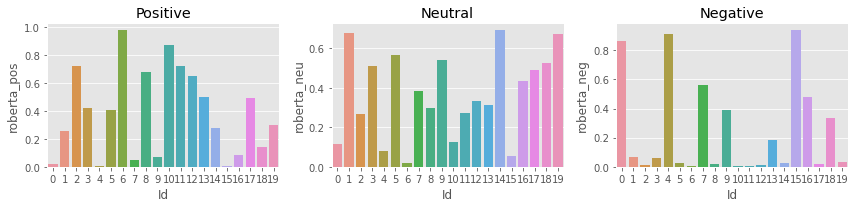

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=roberta, x='Id', y='roberta_pos', ax=axs[0])
sns.barplot(data=roberta, x='Id', y='roberta_neu', ax=axs[1])
sns.barplot(data=roberta, x='Id', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()